In [1]:
import sounddevice as sd
import wave
import tkinter as tk
from tkinter import messagebox
import threading
import numpy as np
import seaborn as sns
from tkinter import filedialog
import warnings
  
from keras import models
from keras import layers
from tensorflow.compat.v1 import ConfigProto  # type: ignore
from tensorflow.compat.v1 import InteractiveSession  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical # type: ignore
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import time
from keras_tuner.tuners import BayesianOptimization # type: ignore 
import librosa
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif


In [2]:
data = pd.read_csv('D:\\ML PROJECT\\dataset.csv')
X = data.drop('target', axis=1)  # Replace 'target' with your actual target column name
y = data['target'] 

In [3]:
# One-hot encode the target
encoder = OneHotEncoder()
y = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [5]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Define the MLP model builder function
def build_model(hp):
    model = models.Sequential()

    # First layer with variable number of units
    model.add(layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), 
                           activation='relu', input_shape=(X_train.shape[1],)))

    # Add variable number of layers and units
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32),
                               activation='relu'))
    
    # Output layer
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
# Instantiate the BayesianOptimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of trials to run the search
    executions_per_trial=1,  # Number of times to evaluate each trial
    directory='mlp_tuning',  # Folder to save results
    project_name='emotion_classification'
)

c:\Windows.old\Users\sathv\Local Settings\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Perform the search for best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 12s]
val_accuracy: 0.5798611044883728

Best val_accuracy So Far: 0.6388888955116272
Total elapsed time: 00h 02m 59s


In [16]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model and train
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2648 - loss: 1.9661 - val_accuracy: 0.4340 - val_loss: 1.6642
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4996 - loss: 1.3968 - val_accuracy: 0.4132 - val_loss: 1.5971
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 1.1947 - val_accuracy: 0.5104 - val_loss: 1.4097
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6203 - loss: 1.0431 - val_accuracy: 0.4826 - val_loss: 1.4706
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6488 - loss: 0.9421 - val_accuracy: 0.5278 - val_loss: 1.3613
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7320 - loss: 0.7481 - val_accuracy: 0.5312 - val_loss: 1.3502
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7399 - loss: 0.6617 - val_accuracy: 0.5347 - val_loss: 1.5182
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8147 - loss: 0.5750 - val_accuracy: 0.5660 - v

In [17]:
# Evaluate the final model
results = model.evaluate(X_test, y_test)
print(f"Test accuracy: {results[1]}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6189 - loss: 3.6238
Test accuracy: 0.6041666865348816


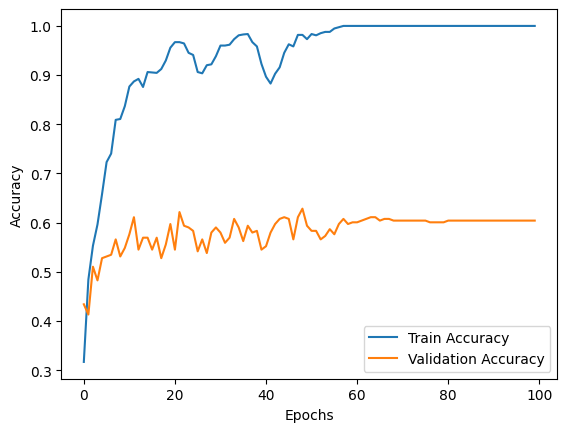

In [18]:
#Plot the training history if desired
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
# Save the trained model
best_model_path = 'D:\\ML PROJECT\\Best models\\emotion_classification_model.keras'  # Define your model file name
model.save(best_model_path)  # Save the model
print(f'Model saved to {best_model_path}')

NameError: name 'model' is not defined

In [27]:
import tensorflow as tf
best_model = tf.keras.models.load_model('D:\\ML PROJECT\\Best models\\emotion_classification_model.keras')

In [9]:
from tensorflow.keras.models import load_model  # type: ignore

# Load the model
loaded_model = load_model(best_model_path)
print('Model Loaded')

# Now you can use loaded_model to make predictions or evaluate it


ValueError: File not found: filepath=D:\ML PROJECT\Best models\emotion_classification_model.keras. Please ensure the file is an accessible `.keras` zip file.